In [8]:
# Import the necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2 
import scipy.io as sio
import scipy.ndimage
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


In [9]:
input_path = '/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/data_HR/'
output_path = '/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/outputs/srcnn/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [10]:
# Load high-resolution data generated from MATLAB code
hr_files = sorted(glob.glob('/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/data_HR/matlab_data/data*'))

high_res_data = []
for file in hr_files:
    mat_data = sio.loadmat(file)
    # Extract vorticity field 'omg' as mentioned in the paper
    high_res_data.append(mat_data['omg'])
    
high_res_data = np.array(high_res_data)  # Shape: [n_samples, 128, 128]
print(high_res_data.shape)

(256, 128, 128)


In [25]:
from scipy.ndimage import zoom

def average_downsample(data, target_size=(16, 16)):
    """Perform average downsampling on the input data"""
    n_samples = data.shape[0]
    low_res_data = np.zeros((n_samples, target_size[0], target_size[1]))
    
    for i in range(n_samples):
        # Reshape to perform average pooling
        h, w = data[i].shape
        pool_size = (h // target_size[0], w // target_size[1])
        reshaped = data[i].reshape(target_size[0], pool_size[0], 
                                  target_size[1], pool_size[1])
        low_res_data[i] = reshaped.mean(axis=(1, 3))
    
    return low_res_data

# Generate low-resolution data
low_res_data_8x8 = average_downsample(high_res_data, target_size=(8, 8))
low_res_data_16x16 = average_downsample(high_res_data, target_size=(16,16))
print(low_res_data_8x8.shape)
print(low_res_data_16x16.shape)

(256, 8, 8)
(256, 16, 16)


In [40]:
from sklearn.model_selection import train_test_split

# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    low_res_data_16x16, high_res_data, test_size=0.2, random_state=42
)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Check the sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 204, Validation: 26, Test: 26


Using device: cuda
Epoch 1/15000, Train Loss: 92.513449, Val Loss: 54.559865
Epoch 2/15000, Train Loss: 53.925846, Val Loss: 50.310379
Epoch 3/15000, Train Loss: 49.727389, Val Loss: 47.237899
Epoch 4/15000, Train Loss: 47.808273, Val Loss: 46.066748
Epoch 5/15000, Train Loss: 46.540738, Val Loss: 44.969311
Epoch 6/15000, Train Loss: 45.494914, Val Loss: 44.070211
Epoch 7/15000, Train Loss: 44.590168, Val Loss: 43.198212
Epoch 8/15000, Train Loss: 43.789377, Val Loss: 42.480575
Epoch 9/15000, Train Loss: 43.060266, Val Loss: 41.762545
Epoch 10/15000, Train Loss: 42.334053, Val Loss: 41.067871
Epoch 11/15000, Train Loss: 41.688203, Val Loss: 40.483838
Epoch 12/15000, Train Loss: 41.075854, Val Loss: 40.138055
Epoch 13/15000, Train Loss: 40.553890, Val Loss: 39.473816
Epoch 14/15000, Train Loss: 39.899310, Val Loss: 38.774671
Epoch 15/15000, Train Loss: 39.376594, Val Loss: 38.339215
Epoch 16/15000, Train Loss: 38.856036, Val Loss: 38.193795
Epoch 17/15000, Train Loss: 38.492833, Val Los

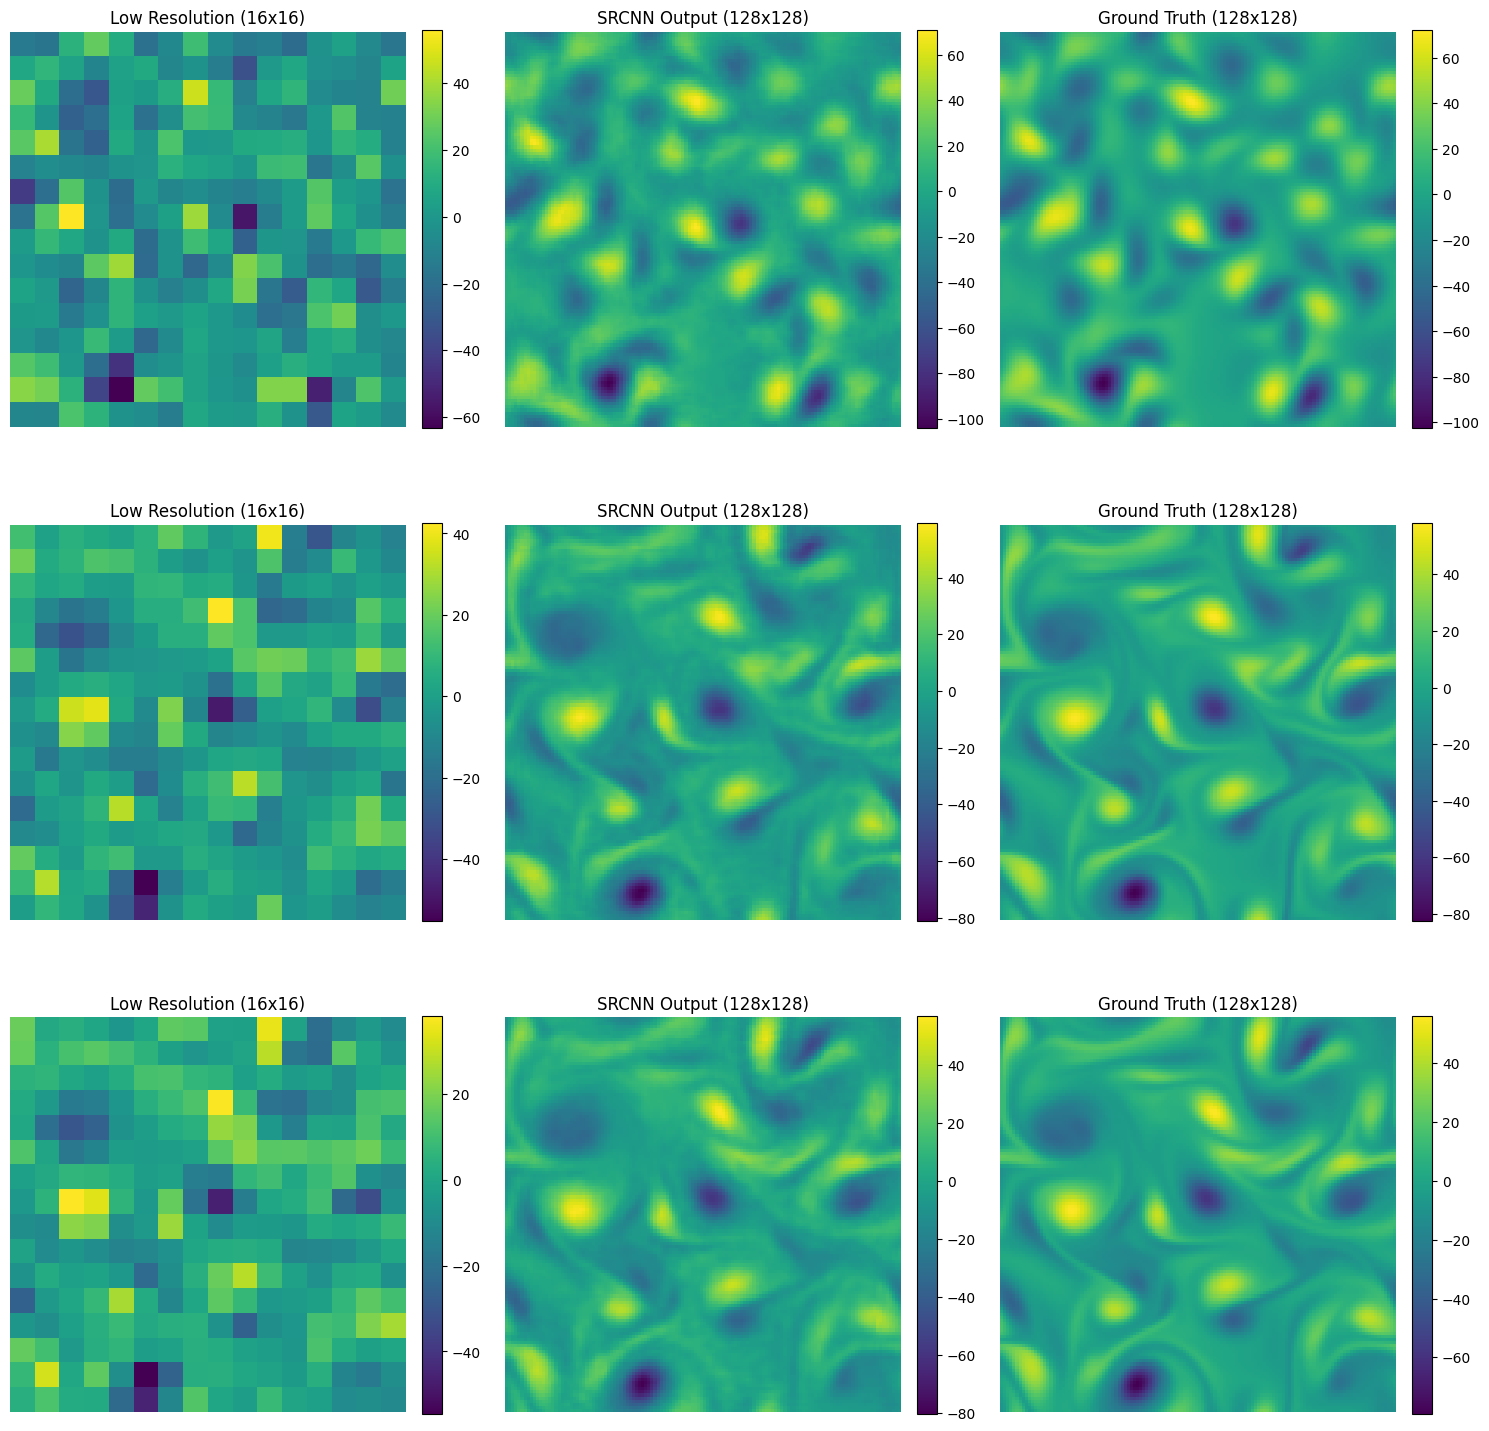

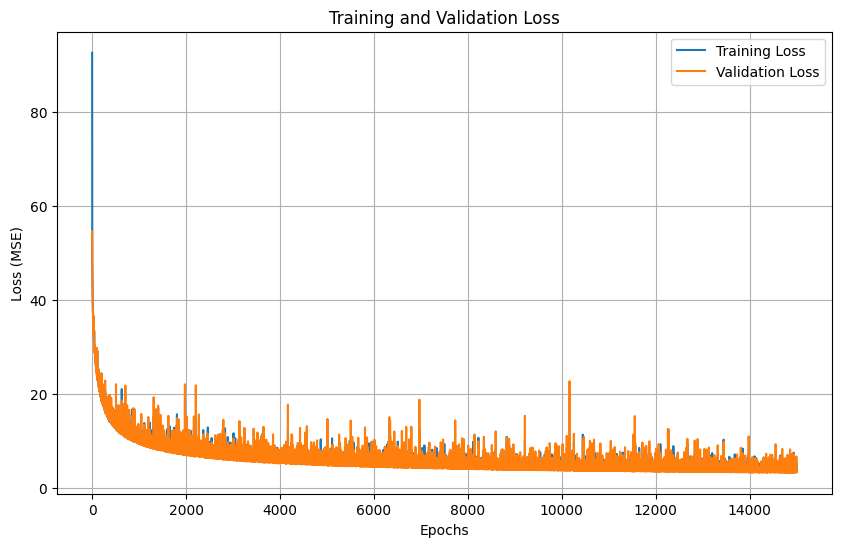

Test Metrics:
MSE: 3.204606
PSNR: 32.258114
NRMSE: 0.010068


In [ ]:
# %% 
# SRCNN Dataset class
class FlowDataset(Dataset):
    def __init__(self, low_res_data, high_res_data, transform=None):
        self.low_res_data = low_res_data
        self.high_res_data = high_res_data
        self.transform = transform
        
    def __len__(self):
        return len(self.low_res_data)
    
    def __getitem__(self, idx):
        lr_sample = self.low_res_data[idx]
        hr_sample = self.high_res_data[idx]
        
        # Convert to tensors and add channel dimension
        lr_tensor = torch.FloatTensor(lr_sample).unsqueeze(0)
        hr_tensor = torch.FloatTensor(hr_sample).unsqueeze(0)
        
        # Bicubic upsample LR to HR size (preprocessing step for SRCNN)
        lr_upsampled = torch.nn.functional.interpolate(
            lr_tensor.unsqueeze(0), 
            size=(128, 128), 
            mode='bicubic', 
            align_corners=False
        ).squeeze(0)
        
        if self.transform:
            lr_upsampled = self.transform(lr_upsampled)
            hr_tensor = self.transform(hr_tensor)
            
        return lr_upsampled, hr_tensor

# %% 
# SRCNN Model definition
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Following the standard SRCNN architecture with 3 convolutional layers
        # Layer 1: Patch extraction and representation
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        
        # Layer 2: Non-linear mapping
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Layer 3: Reconstruction
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

# %% 
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                running_val_loss += val_loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')
        
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), os.path.join(output_path, 'best_srcnn_model.pth'))
    
    return train_losses, val_losses

# %% 
# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            
            # Store predictions and targets
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    all_preds = np.concatenate([p for p in all_preds], axis=0)
    all_targets = np.concatenate([t for t in all_targets], axis=0)
    
    return test_loss, all_preds, all_targets

# %% 
# Main execution
# Create datasets
train_dataset = FlowDataset(X_train, y_train)
val_dataset = FlowDataset(X_val, y_val)
test_dataset = FlowDataset(X_test, y_test)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss function and optimizer
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15000
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Load best model for evaluation
model.load_state_dict(torch.load(os.path.join(output_path, 'best_srcnn_model.pth')))

# Evaluate on test set
test_loss, test_preds, test_targets = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.6f}')

# %% 
# Visualization function
def visualize_results(low_res, predictions, targets, indices, save_path=None):
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5*len(indices)))
    
    if len(indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Get the original low-res image (16x16)
        lr_img = low_res[idx].squeeze()
        
        # Display low resolution
        im0 = axes[i, 0].imshow(lr_img, cmap='viridis')
        axes[i, 0].set_title(f'Low Resolution (16x16)')
        axes[i, 0].axis('off')
        
        # Display super-resolved prediction
        im1 = axes[i, 1].imshow(predictions[idx].squeeze(), cmap='viridis')
        axes[i, 1].set_title(f'SRCNN Output (128x128)')
        axes[i, 1].axis('off')
        
        # Display high resolution target
        im2 = axes[i, 2].imshow(targets[idx].squeeze(), cmap='viridis')
        axes[i, 2].set_title(f'Ground Truth (128x128)')
        axes[i, 2].axis('off')
        
        plt.colorbar(im0, ax=axes[i, 0], fraction=0.046, pad=0.04)
        plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)
        plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")
    
    plt.show()

# %% 
# Visualize sample results
sample_indices = [0, 5, 10]  # Choose some sample indices
visualize_results(X_test, test_preds, test_targets, sample_indices, 
                  save_path=os.path.join(output_path, 'srcnn_results.png'))

# %% 
# Compute and plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_path, 'loss_curves.png'), dpi=300)
plt.show()

# %% 
# Calculate metrics
def calculate_metrics(predictions, targets):
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((predictions - targets) ** 2)
    
    # Calculate Peak Signal-to-Noise Ratio (PSNR)
    max_pixel = np.max(targets)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    # Calculate Normalized Root Mean Square Error (NRMSE)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(targets) - np.min(targets))
    
    return {
        'MSE': mse,
        'PSNR': psnr,
        'NRMSE': nrmse
    }

# Calculate metrics on test set
metrics = calculate_metrics(test_preds, test_targets)
print("Test Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

# Save metrics to file
with open(os.path.join(output_path, 'metrics.txt'), 'w') as f:
    f.write("Test Metrics:\n")
    for metric_name, value in metrics.items():
        f.write(f"{metric_name}: {value:.6f}\n")